Pearson correlation: 0.1676 (p-value: 0.0000)
Spearman correlation: 0.2874 (p-value: 0.0000)


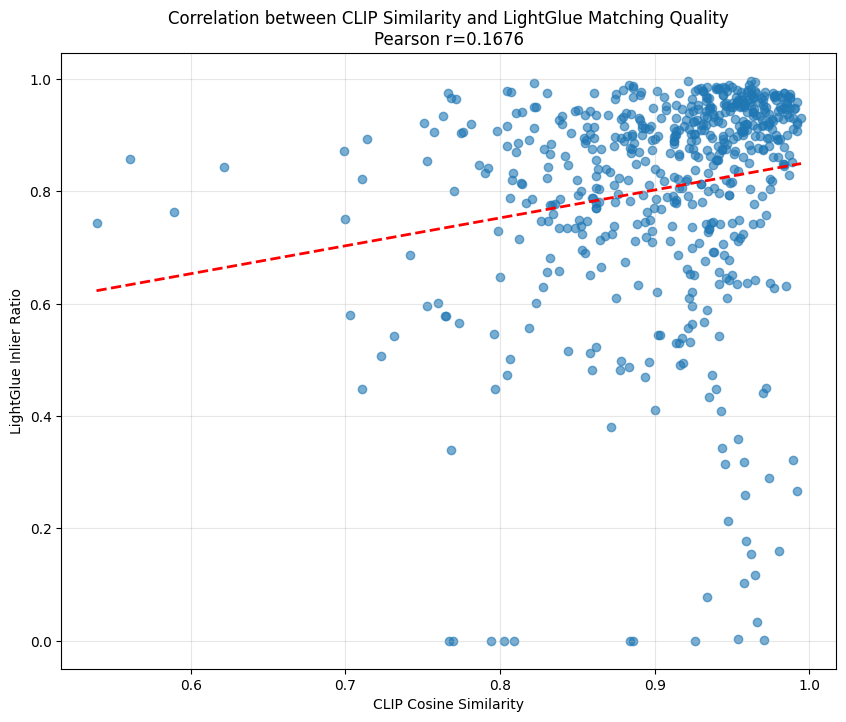

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

lightglue_results = np.load("results_superpoint_20250327_000236/results.npz", allow_pickle=True)['results']
clip_results = np.load("clip_results_ViT-B_32_20250327_003619/clip_similarity_results.npz", allow_pickle=True)['results']

def create_pair_mapping(results, key_func):
    mapping = {}
    for r in results:
        key = key_func(r)
        mapping[key] = r
    return mapping

def get_pair_key(result):
    seq = result.get('sequence', '')
    pair = result.get('pair', '')
    return f"{seq}_{pair}"

lightglue_map = create_pair_mapping(lightglue_results, get_pair_key)
clip_map = create_pair_mapping(clip_results, get_pair_key)

# Find common pairs
common_keys = set(lightglue_map.keys()) & set(clip_map.keys())

# Collect metrics
inlier_ratios = []
cosine_similarities = []
num_matches = []
euclidean_distances = []

for key in common_keys:
    lg_result = lightglue_map[key]
    clip_result = clip_map[key]
    
    inlier_ratios.append(lg_result.get('inlier_ratio', 0))
    num_matches.append(lg_result.get('num_matches', 0))
    cosine_similarities.append(clip_result['similarity_metrics']['cosine_similarity'])
    euclidean_distances.append(clip_result['similarity_metrics']['euclidean_distance'])

# Calculate correlation coefficients
pearson_corr = stats.pearsonr(inlier_ratios, cosine_similarities)
spearman_corr = stats.spearmanr(inlier_ratios, cosine_similarities)

print(f"Pearson correlation: {pearson_corr[0]:.4f} (p-value: {pearson_corr[1]:.4f})")
print(f"Spearman correlation: {spearman_corr[0]:.4f} (p-value: {spearman_corr[1]:.4f})")

# Create scatter plot with regression line
plt.figure(figsize=(10, 8))
plt.scatter(cosine_similarities, inlier_ratios, alpha=0.6)

# Add regression line
z = np.polyfit(cosine_similarities, inlier_ratios, 1)
p = np.poly1d(z)
plt.plot(sorted(cosine_similarities), p(sorted(cosine_similarities)), "r--", linewidth=2)

plt.xlabel("CLIP Cosine Similarity")
plt.ylabel("LightGlue Inlier Ratio")
plt.title(f"Correlation between CLIP Similarity and LightGlue Matching Quality\nPearson r={pearson_corr[0]:.4f}")
plt.grid(alpha=0.3)
plt.savefig("clip_vs_lightglue_correlation.png", dpi=200)

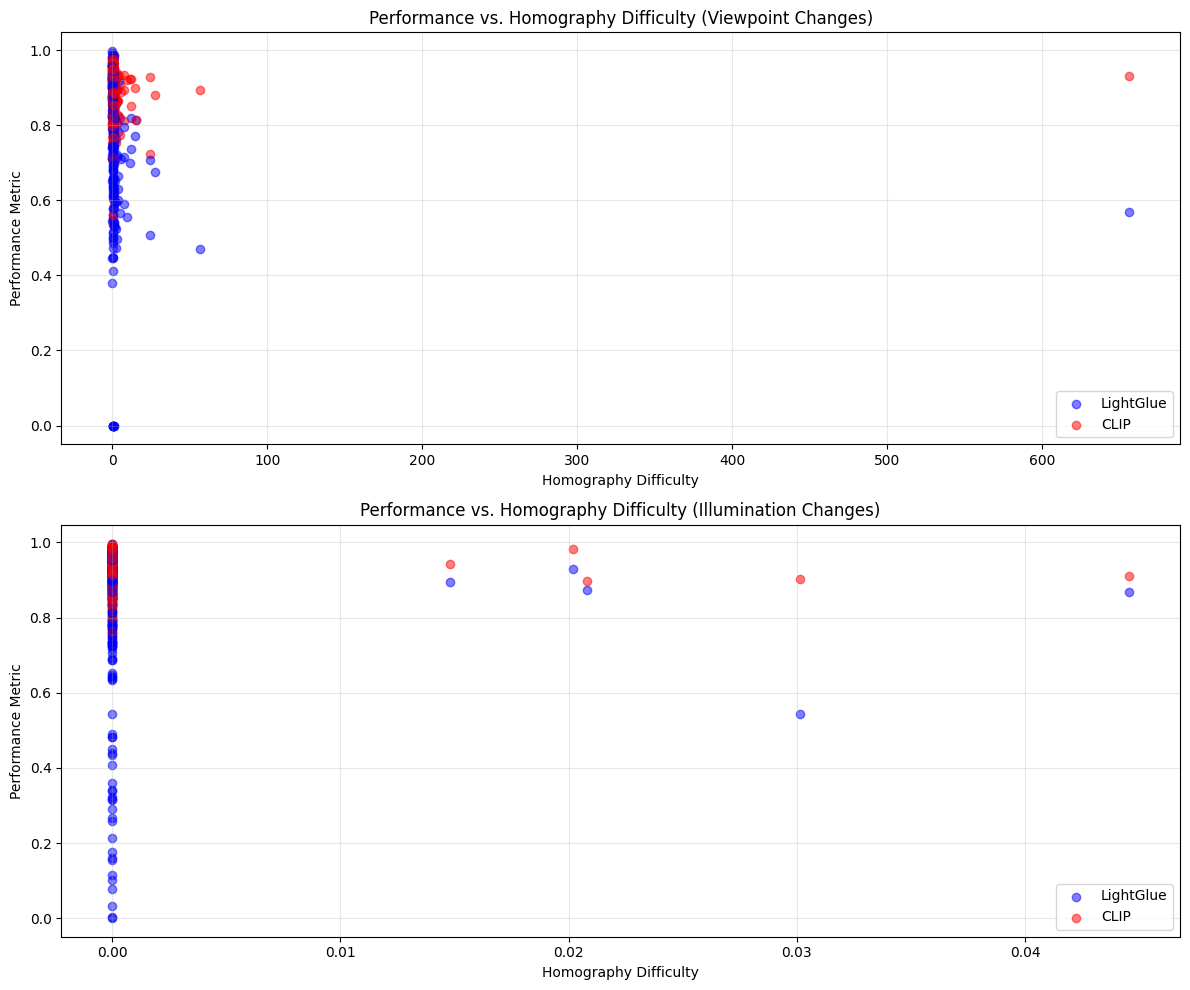

In [2]:
# Categorize by sequence type (viewpoint vs. illumination)
v_pairs = [(k, lightglue_map[k], clip_map[k]) for k in common_keys if k.startswith('v_')]
i_pairs = [(k, lightglue_map[k], clip_map[k]) for k in common_keys if k.startswith('i_')]

# Analyze performance difference by homography difficulty
plt.figure(figsize=(12, 10))

# Subplot for viewpoint changes
plt.subplot(2, 1, 1)
for k, lg, clip in v_pairs:
    h_diff = abs(clip.get('h_det', 1.0) - 1.0)  # Homography difficulty
    x = h_diff
    y1 = lg.get('inlier_ratio', 0)
    y2 = clip['similarity_metrics']['cosine_similarity']
    plt.scatter(x, y1, color='blue', alpha=0.5, label='LightGlue' if 'LightGlue' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.scatter(x, y2, color='red', alpha=0.5, label='CLIP' if 'CLIP' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("Performance vs. Homography Difficulty (Viewpoint Changes)")
plt.xlabel("Homography Difficulty")
plt.ylabel("Performance Metric")
plt.legend()
plt.grid(alpha=0.3)

# Subplot for illumination changes
plt.subplot(2, 1, 2)
for k, lg, clip in i_pairs:
    h_diff = abs(clip.get('h_det', 1.0) - 1.0)
    x = h_diff
    y1 = lg.get('inlier_ratio', 0)
    y2 = clip['similarity_metrics']['cosine_similarity']
    plt.scatter(x, y1, color='blue', alpha=0.5, label='LightGlue' if 'LightGlue' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.scatter(x, y2, color='red', alpha=0.5, label='CLIP' if 'CLIP' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("Performance vs. Homography Difficulty (Illumination Changes)")
plt.xlabel("Homography Difficulty")
plt.ylabel("Performance Metric")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("performance_by_transformation_type.png", dpi=200)

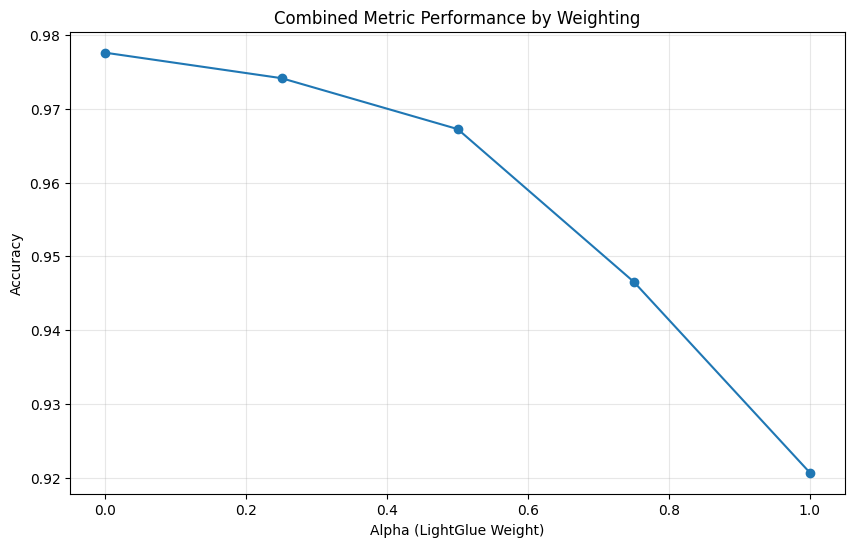

In [3]:
# Create a combined metric that leverages both approaches
def combined_score(lg_result, clip_result, alpha=0.5):
    """
    Create a weighted combination of LightGlue and CLIP scores
    alpha: weight for LightGlue (1-alpha is weight for CLIP)
    """
    lg_score = lg_result.get('inlier_ratio', 0)
    clip_score = clip_result['similarity_metrics']['cosine_similarity']
    
    # Normalize CLIP score to similar range as inlier ratio
    clip_score_normalized = (clip_score - 0.5) * 2 if clip_score > 0.5 else 0
    
    return alpha * lg_score + (1 - alpha) * clip_score_normalized

# Test different weightings
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
results = []

for alpha in alphas:
    combined_scores = []
    ground_truth = []
    
    for key in common_keys:
        lg_result = lightglue_map[key]
        clip_result = clip_map[key]
        
        score = combined_score(lg_result, clip_result, alpha)
        combined_scores.append(score)
        
        # Define "ground truth" as matching sequence
        # This is simplistic - you might use a better metric
        is_same_seq = lg_result.get('sequence', '') == clip_result.get('sequence', '')
        ground_truth.append(1 if is_same_seq else 0)
    
    # Calculate accuracy, precision, etc.
    threshold = 0.5
    predictions = [1 if s >= threshold else 0 for s in combined_scores]
    
    # Simple accuracy
    accuracy = sum(p == gt for p, gt in zip(predictions, ground_truth)) / len(predictions)
    results.append((alpha, accuracy))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot([r[0] for r in results], [r[1] for r in results], 'o-')
plt.xlabel("Alpha (LightGlue Weight)")
plt.ylabel("Accuracy")
plt.title("Combined Metric Performance by Weighting")
plt.grid(alpha=0.3)
plt.savefig("combined_metric_performance.png", dpi=200)

In [11]:
clip_map

{'v_coffeehouse_1.ppm-2.ppm': {'sequence': 'v_coffeehouse',
  'pair': '1.ppm-2.ppm',
  'similarity_metrics': {'cosine_similarity': 0.896484375,
   'euclidean_distance': 0.45654296875,
   'manhattan_distance': 8.0859375,
   'dot_product': 0.89599609375},
  'extract_time': 0.2814655303955078,
  'compute_time': 0.0005314350128173828,
  'total_time': 0.2819969654083252,
  'is_consistent': np.True_,
  'h_det': 0.4093559260106983},
 'v_coffeehouse_1.ppm-3.ppm': {'sequence': 'v_coffeehouse',
  'pair': '1.ppm-3.ppm',
  'similarity_metrics': {'cosine_similarity': 0.86865234375,
   'euclidean_distance': 0.513671875,
   'manhattan_distance': 8.71875,
   'dot_product': 0.8681640625},
  'extract_time': 0.04475855827331543,
  'compute_time': 0.00012230873107910156,
  'total_time': 0.04488086700439453,
  'is_consistent': np.True_,
  'h_det': 1.189902397114103},
 'v_coffeehouse_1.ppm-4.ppm': {'sequence': 'v_coffeehouse',
  'pair': '1.ppm-4.ppm',
  'similarity_metrics': {'cosine_similarity': 0.75244140

Mean Squared Error: 0.0376
R² Score: 0.0199


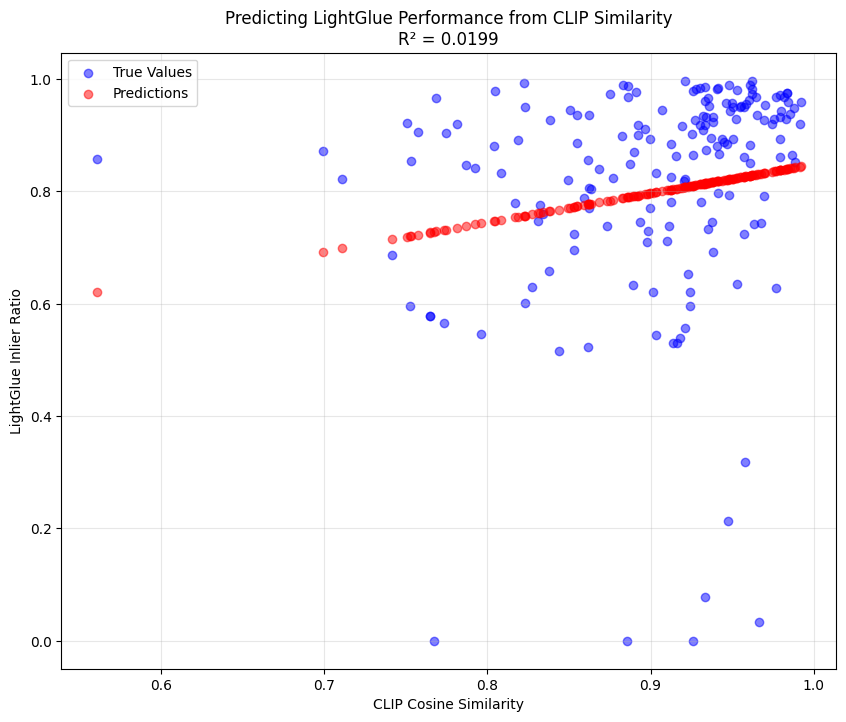

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Can we predict LightGlue performance from CLIP similarity?
X = np.array(cosine_similarities).reshape(-1, 1)
y = np.array(inlier_ratios)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot results
plt.figure(figsize=(10, 8))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='True Values')
plt.scatter(X_test, y_pred, color='red', alpha=0.5, label='Predictions')
plt.xlabel("CLIP Cosine Similarity")
plt.ylabel("LightGlue Inlier Ratio")
plt.title(f"Predicting LightGlue Performance from CLIP Similarity\nR² = {r2:.4f}")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("prediction_model.png", dpi=200)

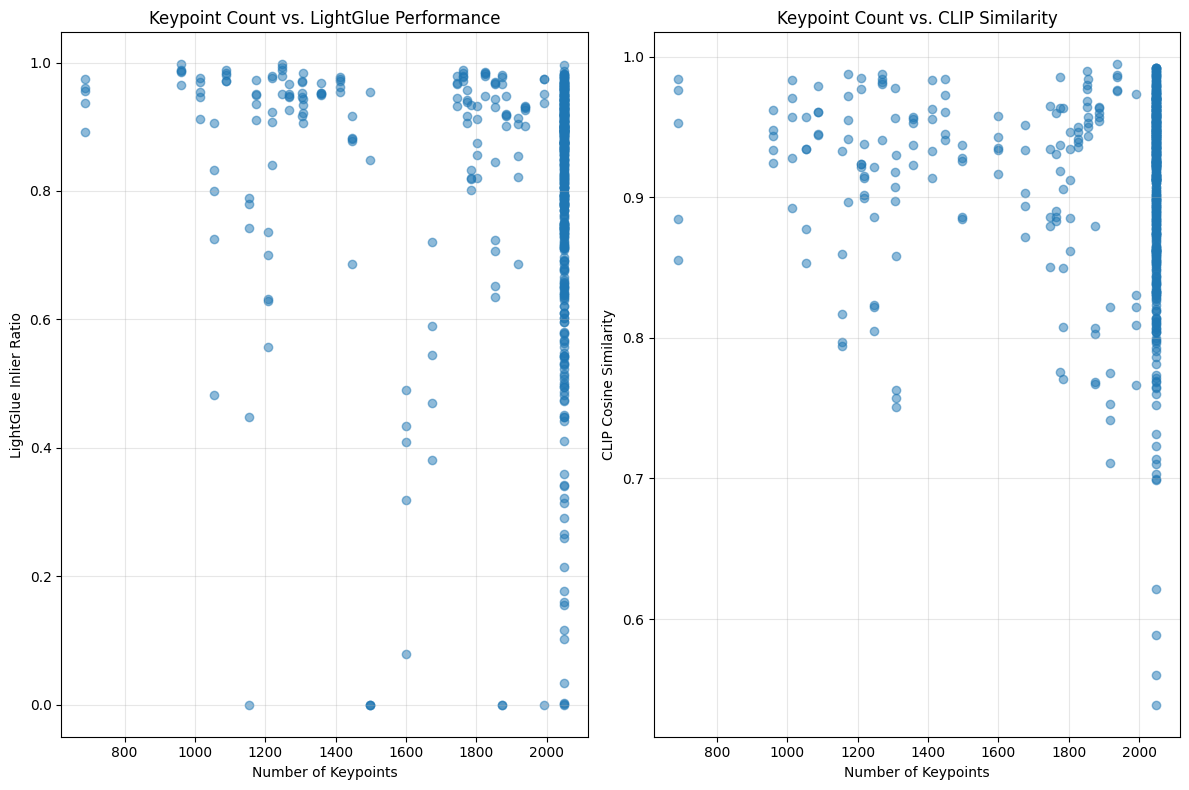

In [11]:
# Analyze how keypoint count affects both methods
plt.figure(figsize=(12, 8))

# Get keypoint counts
keypoint_counts = [lightglue_map[k].get('num_keypoints1', 0) for k in common_keys]

# Plot relationship between keypoint count and performance
plt.subplot(1, 2, 1)
plt.scatter(keypoint_counts, inlier_ratios, alpha=0.5)
plt.xlabel("Number of Keypoints")
plt.ylabel("LightGlue Inlier Ratio")
plt.title("Keypoint Count vs. LightGlue Performance")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(keypoint_counts, cosine_similarities, alpha=0.5)
plt.xlabel("Number of Keypoints")
plt.ylabel("CLIP Cosine Similarity")
plt.title("Keypoint Count vs. CLIP Similarity")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("keypoint_impact.png", dpi=200)

In [12]:
# Find pairs where methods strongly disagree
disagreement_scores = []

for key in common_keys:
    lg_result = lightglue_map[key]
    clip_result = clip_map[key]
    
    lg_score = lg_result.get('inlier_ratio', 0)
    clip_score = clip_result['similarity_metrics']['cosine_similarity']
    
    # Normalize CLIP score to similar range as inlier ratio
    clip_score_normalized = (clip_score - 0.5) * 2 if clip_score > 0.5 else 0
    
    # Calculate disagreement
    disagreement = abs(lg_score - clip_score_normalized)
    disagreement_scores.append((key, disagreement, lg_score, clip_score_normalized))

# Sort by disagreement
disagreement_scores.sort(key=lambda x: x[1], reverse=True)

# Analyze top disagreement cases
top_n = 10
print("Top disagreement cases:")
for i, (key, disagreement, lg_score, clip_score) in enumerate(disagreement_scores[:top_n]):
    print(f"{i+1}. {key}: LightGlue={lg_score:.2f}, CLIP={clip_score:.2f}, Diff={disagreement:.2f}")

# Visualize some of these pairs
# (Requires that you have access to the original images)

Top disagreement cases:
1. i_pencils_1.ppm-3.ppm: LightGlue=0.00, CLIP=0.94, Diff=0.94
2. i_pencils_1.ppm-4.ppm: LightGlue=0.00, CLIP=0.91, Diff=0.90
3. i_londonbridge_1.ppm-5.ppm: LightGlue=0.03, CLIP=0.93, Diff=0.90
4. v_bark_1.ppm-6.ppm: LightGlue=0.00, CLIP=0.85, Diff=0.85
5. i_dc_1.ppm-6.ppm: LightGlue=0.10, CLIP=0.92, Diff=0.81
6. i_dc_1.ppm-5.ppm: LightGlue=0.12, CLIP=0.93, Diff=0.81
7. i_brooklyn_1.ppm-5.ppm: LightGlue=0.16, CLIP=0.96, Diff=0.80
8. i_tools_1.ppm-6.ppm: LightGlue=0.08, CLIP=0.87, Diff=0.79
9. v_bark_1.ppm-3.ppm: LightGlue=0.00, CLIP=0.77, Diff=0.77
10. i_dc_1.ppm-4.ppm: LightGlue=0.15, CLIP=0.92, Diff=0.77


In [14]:
import cv2

def visualize_method_comparison(image1_path, image2_path, lg_result, clip_result):
    """Create a visualization comparing LightGlue and CLIP results for an image pair"""
    # Load images
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Get metrics
    inlier_ratio = lg_result.get('inlier_ratio', 0)
    num_matches = lg_result.get('num_matches', 0)
    cosine_sim = clip_result['similarity_metrics']['cosine_similarity']
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot images
    plt.subplot(2, 2, 1)
    plt.imshow(img1_rgb)
    plt.title("Image 1")
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(img2_rgb)
    plt.title("Image 2")
    plt.axis('off')
    
    # Plot metrics
    plt.subplot(2, 1, 2)
    metrics = [inlier_ratio, cosine_sim]
    plt.bar(['LightGlue Inlier Ratio', 'CLIP Cosine Similarity'], metrics, color=['blue', 'red'])
    plt.ylim([0, 1])
    plt.grid(alpha=0.3)
    plt.title(f"Comparison of Methods (Matches: {num_matches})")
    
    plt.tight_layout()
    return plt

# Test on a few pairs
for key in list(common_keys)[:5]:
    lg_result = lightglue_map[key]
    clip_result = clip_map[key]
    
    # You'll need to construct the actual image paths from the key
    seq_name = lg_result.get('sequence', '')
    pair_names = lg_result.get('pair', '').split('-')
    
    img1_path = f"/home/rizaev2/MMKUZNECOV/PR_project/LightGlue/data/hpatches-sequences-release/{seq_name}/{pair_names[0]}"
    img2_path = f"/home/rizaev2/MMKUZNECOV/PR_project/LightGlue/data/hpatches-sequences-release/{seq_name}/{pair_names[1]}"
    
    # Create visualization
    plt = visualize_method_comparison(img1_path, img2_path, lg_result, clip_result)
    plt.savefig(f"comparison_{seq_name}_{pair_names[0]}_{pair_names[1]}.png", dpi=200)
    plt.close()

easy: LightGlue=0.8387, CLIP=0.9340, Ratio=0.8979
medium: LightGlue=0.8347, CLIP=0.8933, Ratio=0.9344
hard: LightGlue=0.7506, CLIP=0.8718, Ratio=0.8610


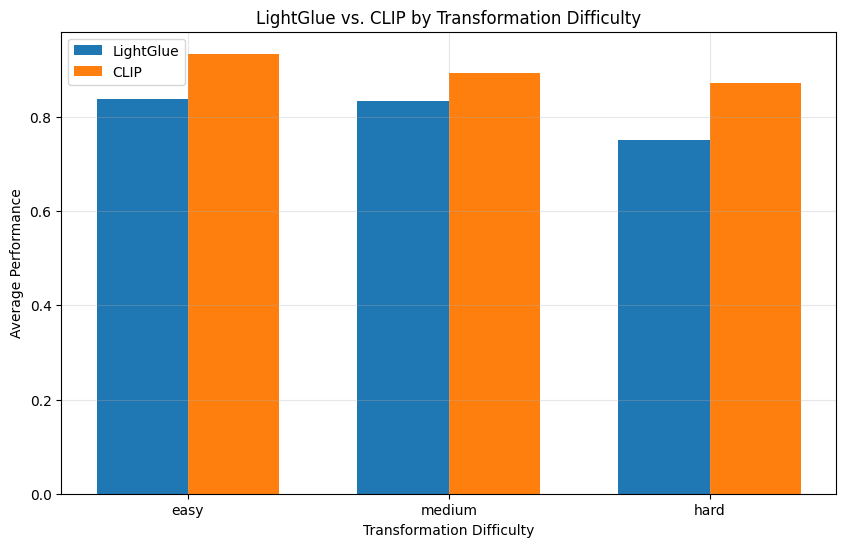

In [15]:
# Group by transformation difficulty
difficulty_levels = {
    'easy': [],
    'medium': [],
    'hard': []
}

for key in common_keys:
    clip_result = clip_map[key]
    h_diff = abs(clip_result.get('h_det', 1.0) - 1.0)
    
    if h_diff < 0.2:
        category = 'easy'
    elif h_diff < 0.5:
        category = 'medium'
    else:
        category = 'hard'
    
    lg_result = lightglue_map[key]
    inlier_ratio = lg_result.get('inlier_ratio', 0)
    cosine_sim = clip_result['similarity_metrics']['cosine_similarity']
    
    difficulty_levels[category].append((inlier_ratio, cosine_sim))

# Calculate average performance by difficulty
for category, values in difficulty_levels.items():
    if values:
        avg_lg = np.mean([v[0] for v in values])
        avg_clip = np.mean([v[1] for v in values])
        print(f"{category}: LightGlue={avg_lg:.4f}, CLIP={avg_clip:.4f}, Ratio={avg_lg/avg_clip:.4f}")

# Plot comparison
categories = list(difficulty_levels.keys())
lg_avgs = [np.mean([v[0] for v in difficulty_levels[c]]) if difficulty_levels[c] else 0 for c in categories]
clip_avgs = [np.mean([v[1] for v in difficulty_levels[c]]) if difficulty_levels[c] else 0 for c in categories]

plt.figure(figsize=(10, 6))
x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, lg_avgs, width, label='LightGlue')
plt.bar(x + width/2, clip_avgs, width, label='CLIP')

plt.xlabel('Transformation Difficulty')
plt.ylabel('Average Performance')
plt.title('LightGlue vs. CLIP by Transformation Difficulty')
plt.xticks(x, categories)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("performance_by_difficulty.png", dpi=200)